In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/NO2_aeroequal_and_council.csv')
data.head()

,Datetime,NO2_ppm_aeroequal,NO2_µg/m³_council
0,2024-08-15 15:00:00,0.000000,10.53788
1,2024-08-15 16:00:00,0.000000,14.91272
2,2024-08-15 17:00:00,3.474375,15.33347
3,2024-08-15 18:00:00,8.765625,10.63350
4,2024-08-15 19:00:00,7.012500,11.32200


In [3]:
X = data[['NO2_ppm_aeroequal']].values
y = data['NO2_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[ 0.414375],
       [ 0.      ],
       [ 0.765   ],
       [15.395625],
       [ 0.095625]])

array([[-0.56450609],
       [-0.62517452],
       [-0.51317126],
       [ 1.62889102],
       [-0.61117411]])

array([[5.323125  ],
       [0.80913462],
       [8.67      ],
       [0.        ],
       [3.6975    ]])

array([[ 0.15418147],
       [-0.50670954],
       [ 0.64419572],
       [-0.62517452],
       [-0.08382545]])

#### Experimented List of Models and Parameters

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

params = {
    'Linear Regression': {
        'poly__degree': [1, 2, 3]
    },
    'Ridge': {
        'ridge__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'Lasso': {
        'lasso__alpha': [0.001, 0.01, 0.1],
        'poly__degree': [1, 2, 3]
    },
    'ElasticNet': {
        'elasticnet__alpha': [0.001, 0.01, 0.1],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    },
    'Random Forest': {
        'randomforest__n_estimators': [50, 100, 150, 200],
        'randomforest__max_depth': [5, 7, 10]
    },
    'Gradient Boosting': {
        'gradientboosting__n_estimators': [50, 100, 150, 200],
        'gradientboosting__learning_rate': [0.001, 0.01, 0.1],
        'gradientboosting__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'xgboost__n_estimators': [50, 100, 150, 200],
        'xgboost__learning_rate': [0.001, 0.01, 0.1],
        'xgboost__max_depth': [3, 5, 7],
        'xgboost__subsample': [0.6, 0.8, 1.0]
    },
    'K-Nearest Neighbors': {
        'k-nearestneighbors__n_neighbors': [3, 5, 7, 9],
        'k-nearestneighbors__weights': ['uniform', 'distance'],
        'k-nearestneighbors__p': [1, 2]
    },
    'AdaBoost': {
        'adaboost__n_estimators': [50, 100, 150, 200],
        'adaboost__learning_rate': [0.001, 0.01, 0.1],
        'adaboost__loss': ['linear', 'square', 'exponential']
    }
}

polynomial_models = ['Linear Regression', 'Ridge', 'Lasso']

#### 1. polynomial_models is the list of models for which a polynomial feature transformation is required
#### 2. We create a pipeline for those models to transform the features before feeding them to the model.
#### 3. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 4. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [8]:
best_models = []
best_score = float('-inf')
best_model_name = ''
best_params = {}

for model_name in models:
    print(f"Training {model_name}...")
    steps = []

    if model_name in polynomial_models:
        steps.append(('poly', PolynomialFeatures(include_bias=False)))
        
    model_param_key = model_name.lower().replace(' ', '')
    steps.append((model_param_key, models[model_name]))
    pipeline = Pipeline(steps)
    
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=True)
    
    try:
        grid_search.fit(X_train_scaled, y_train)
        model_score = grid_search.best_score_
        
        best_models.append({
            'name': model_name,
            'model': grid_search.best_estimator_,
            'params': grid_search.best_params_,
            'rmse': model_score
        })

    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training Linear Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Ridge...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Lasso...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training ElasticNet...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Training XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Training AdaBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Results

In [9]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

#### For showcasing model with the best R2

In [10]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: AdaBoost
Best Hyperparameters: {'poly__degree': 1}
Test RMSE: 2.6473
Test MSE: 7.0084
Test R2: -0.0038
Test MAE: 2.2353


,Actual,Predicted
0,9.60075,13.326476
1,12.03919,13.419999
2,13.74609,13.257134
3,12.76116,13.436763
4,14.87447,13.360156
5,11.24550,13.436763
6,19.66528,13.430159
7,11.69972,13.436763
8,10.63350,13.255153
9,11.56584,13.436763


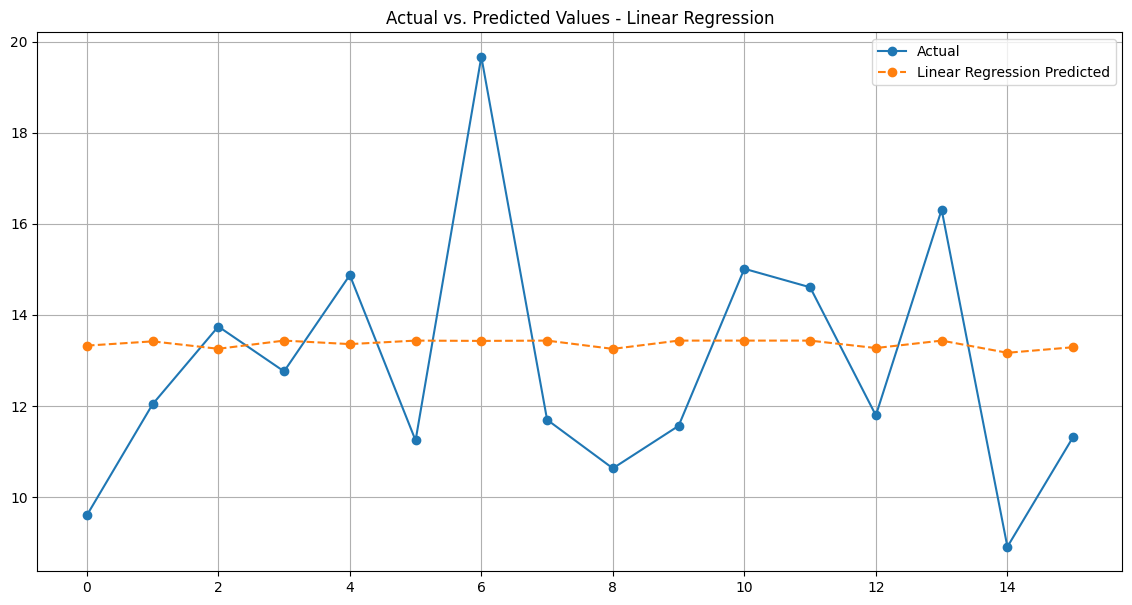


Results For Model: Linear Regression
Best Hyperparameters: {'poly__degree': 1, 'ridge__alpha': 0.1}
Test RMSE: 2.6475
Test MSE: 7.0090
Test R2: -0.0039
Test MAE: 2.2353


,Actual,Predicted
0,9.60075,13.326538
1,12.03919,13.419795
2,13.74609,13.257394
3,12.76116,13.436511
4,14.87447,13.360123
5,11.24550,13.436511
6,19.66528,13.429926
7,11.69972,13.436511
8,10.63350,13.255418
9,11.56584,13.436511


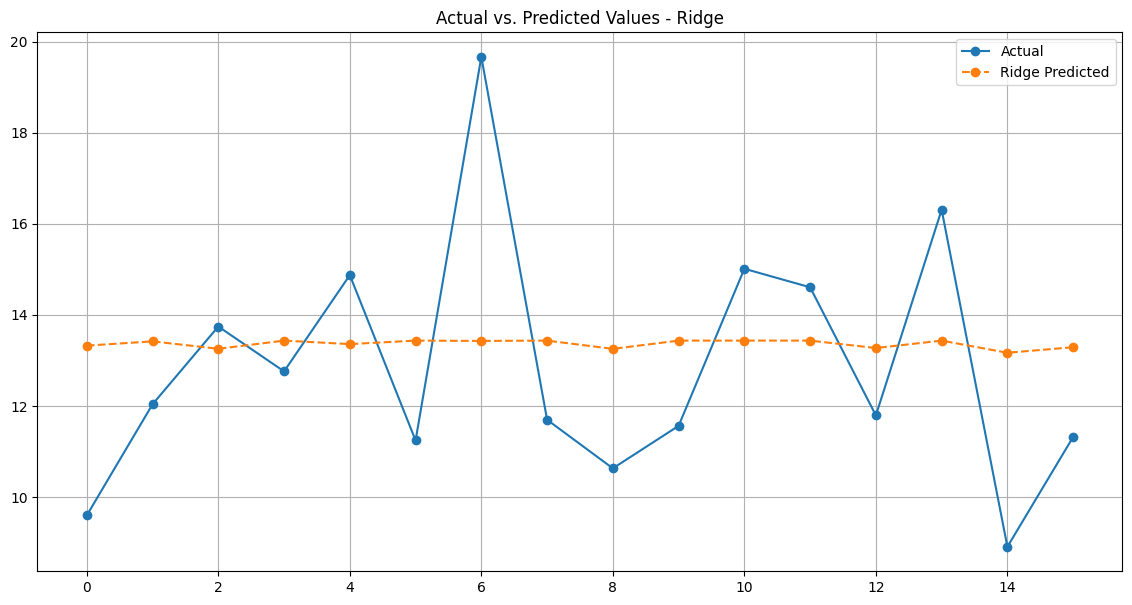


Results For Model: Ridge
Best Hyperparameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
Test RMSE: 2.6723
Test MSE: 7.1410
Test R2: -0.0228
Test MAE: 2.2460


,Actual,Predicted
0,9.60075,13.340431
1,12.03919,13.374137
2,13.74609,13.315440
3,12.76116,13.380178
4,14.87447,13.352569
5,11.24550,13.380178
6,19.66528,13.377798
7,11.69972,13.380178
8,10.63350,13.314726
9,11.56584,13.380178


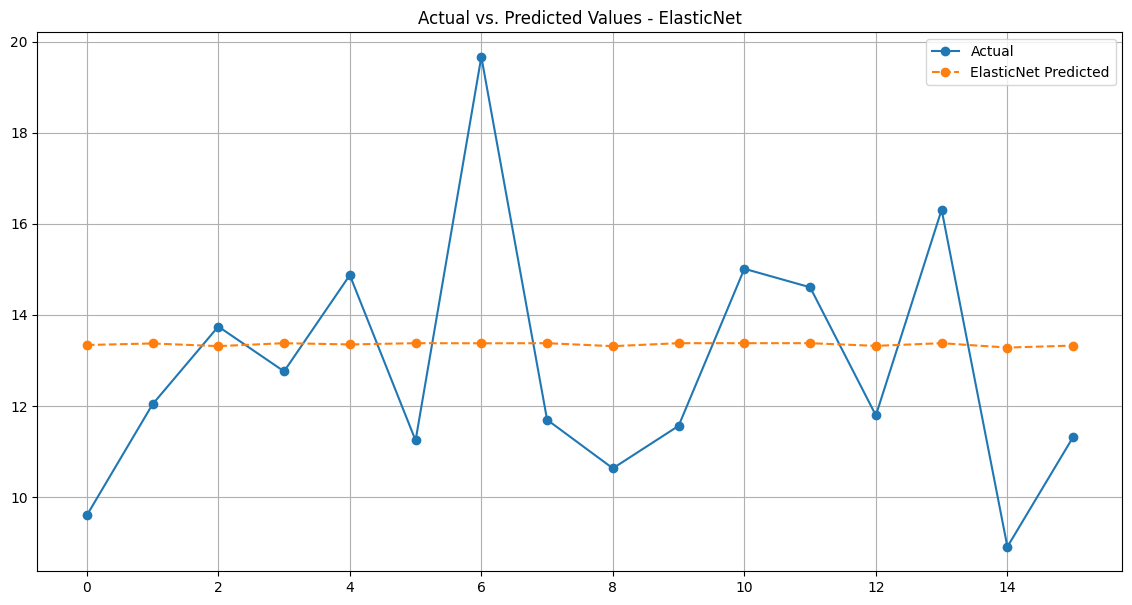


Results For Model: ElasticNet
Best Hyperparameters: {'lasso__alpha': 0.1, 'poly__degree': 1}
Test RMSE: 2.6749
Test MSE: 7.1553
Test R2: -0.0248
Test MAE: 2.2471


,Actual,Predicted
0,9.60075,13.341894
1,12.03919,13.369328
2,13.74609,13.321554
3,12.76116,13.374245
4,14.87447,13.351774
5,11.24550,13.374245
6,19.66528,13.372308
7,11.69972,13.374245
8,10.63350,13.320972
9,11.56584,13.374245


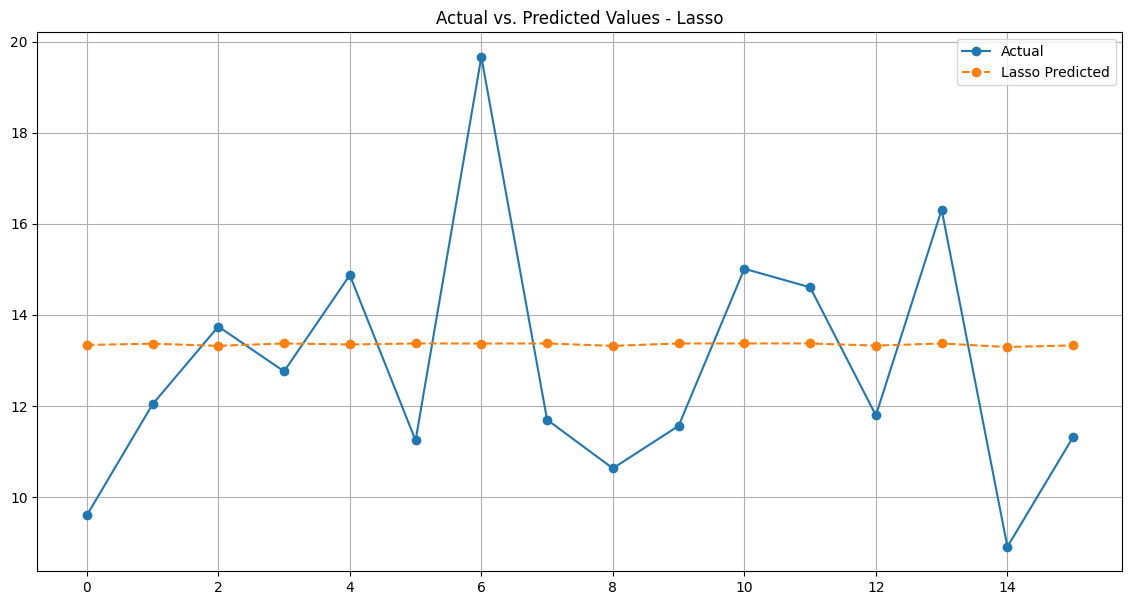


Results For Model: Lasso
Best Hyperparameters: {'xgboost__learning_rate': 0.001, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 50, 'xgboost__subsample': 0.6}
Test RMSE: 2.6979
Test MSE: 7.2789
Test R2: -0.0425
Test MAE: 2.2496


,Actual,Predicted
0,9.60075,13.470643
1,12.03919,13.259982
2,13.74609,13.332167
3,12.76116,13.288644
4,14.87447,13.521799
5,11.24550,13.288644
6,19.66528,13.301360
7,11.69972,13.288644
8,10.63350,13.332167
9,11.56584,13.288644


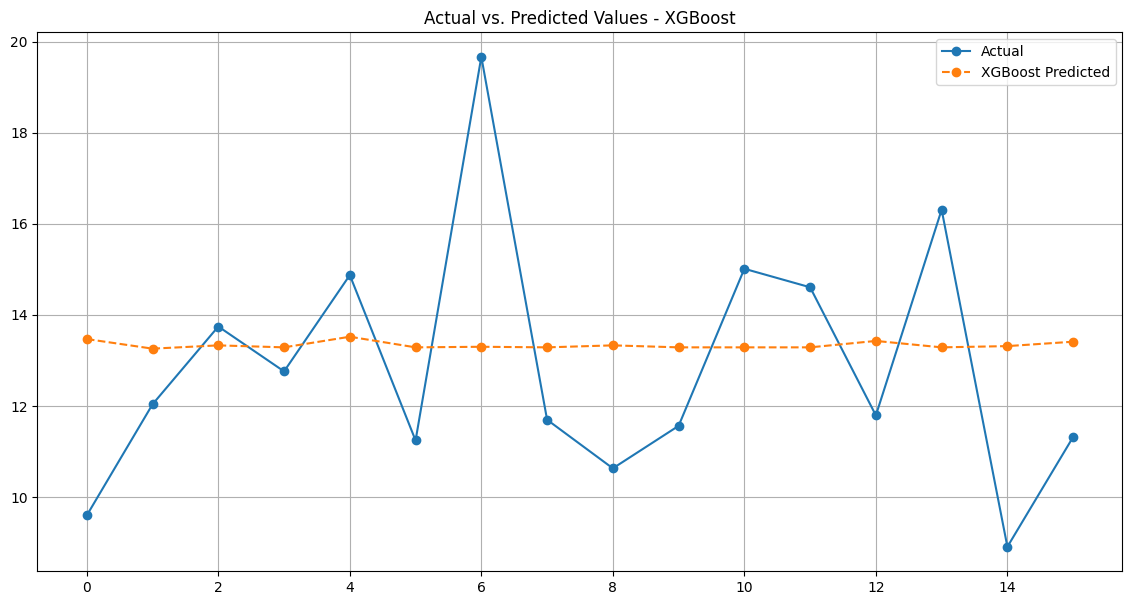


Results For Model: XGBoost
Best Hyperparameters: {'gradientboosting__learning_rate': 0.001, 'gradientboosting__max_depth': 3, 'gradientboosting__n_estimators': 50}
Test RMSE: 2.7036
Test MSE: 7.3094
Test R2: -0.0469
Test MAE: 2.2443


,Actual,Predicted
0,9.60075,13.765945
1,12.03919,13.265015
2,13.74609,13.304277
3,12.76116,13.309919
4,14.87447,13.765945
5,11.24550,13.309919
6,19.66528,13.368007
7,11.69972,13.309919
8,10.63350,13.304277
9,11.56584,13.309919


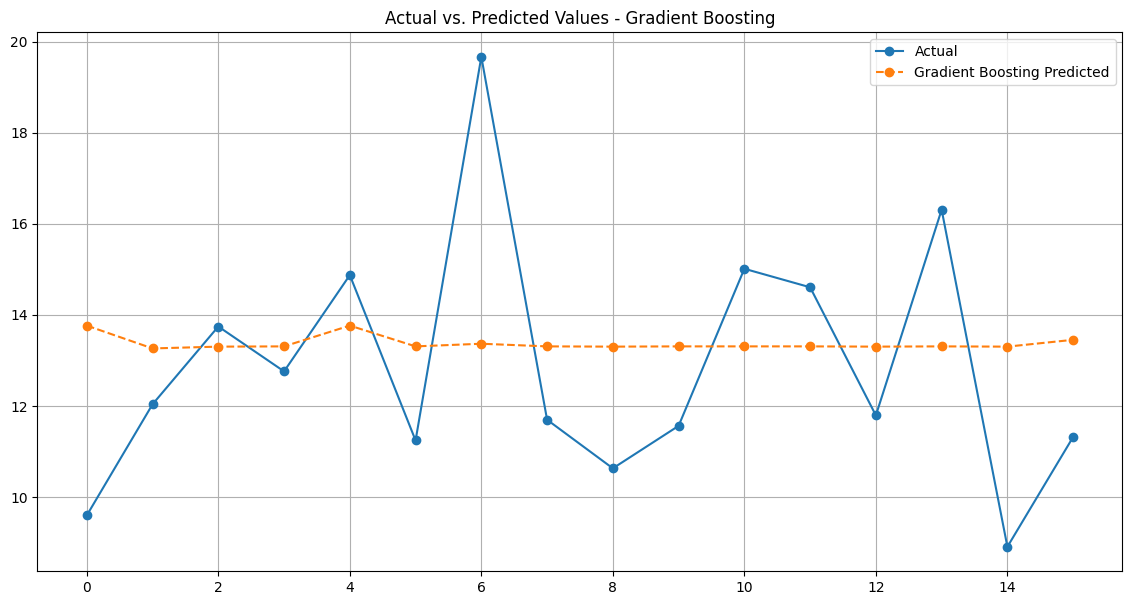


Results For Model: Gradient Boosting
Best Hyperparameters: {'k-nearestneighbors__n_neighbors': 9, 'k-nearestneighbors__p': 1, 'k-nearestneighbors__weights': 'uniform'}
Test RMSE: 3.3643
Test MSE: 11.3186
Test R2: -0.6211
Test MAE: 2.7164


,Actual,Predicted
0,9.60075,15.164000
1,12.03919,12.091251
2,13.74609,15.578376
3,12.76116,12.278250
4,14.87447,14.333126
5,11.24550,12.278250
6,19.66528,13.320032
7,11.69972,12.278250
8,10.63350,15.578376
9,11.56584,12.278250


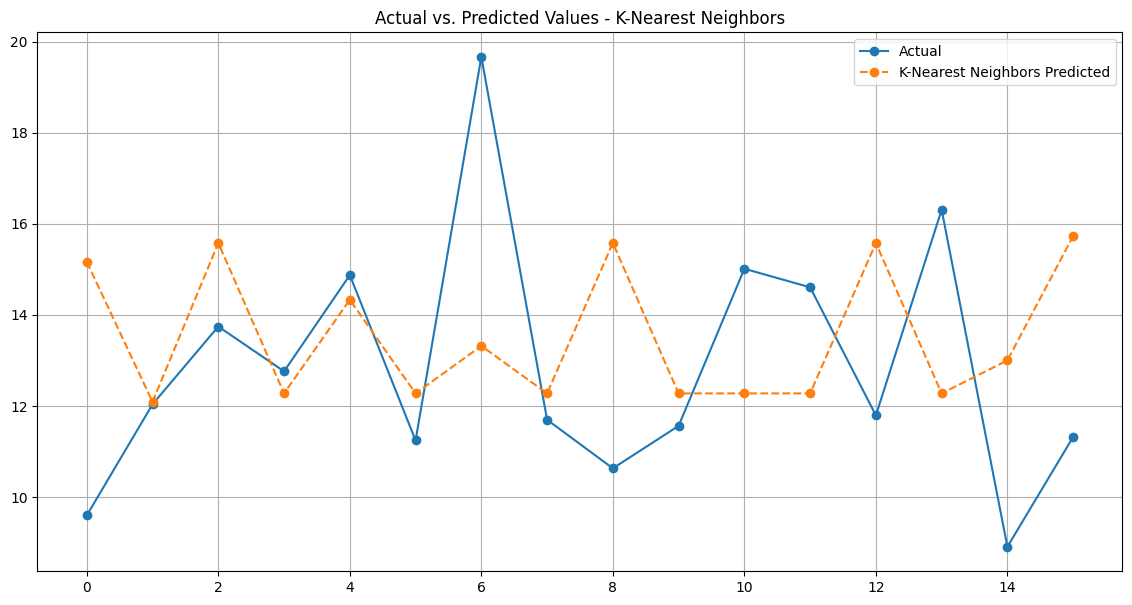


Results For Model: K-Nearest Neighbors
Best Hyperparameters: {'randomforest__max_depth': 5, 'randomforest__n_estimators': 50}
Test RMSE: 3.9725
Test MSE: 15.7805
Test R2: -1.2602
Test MAE: 2.9918


,Actual,Predicted
0,9.60075,18.530139
1,12.03919,12.283934
2,13.74609,13.568810
3,12.76116,12.632823
4,14.87447,20.396310
5,11.24550,12.632823
6,19.66528,12.101196
7,11.69972,12.632823
8,10.63350,13.539166
9,11.56584,12.632823


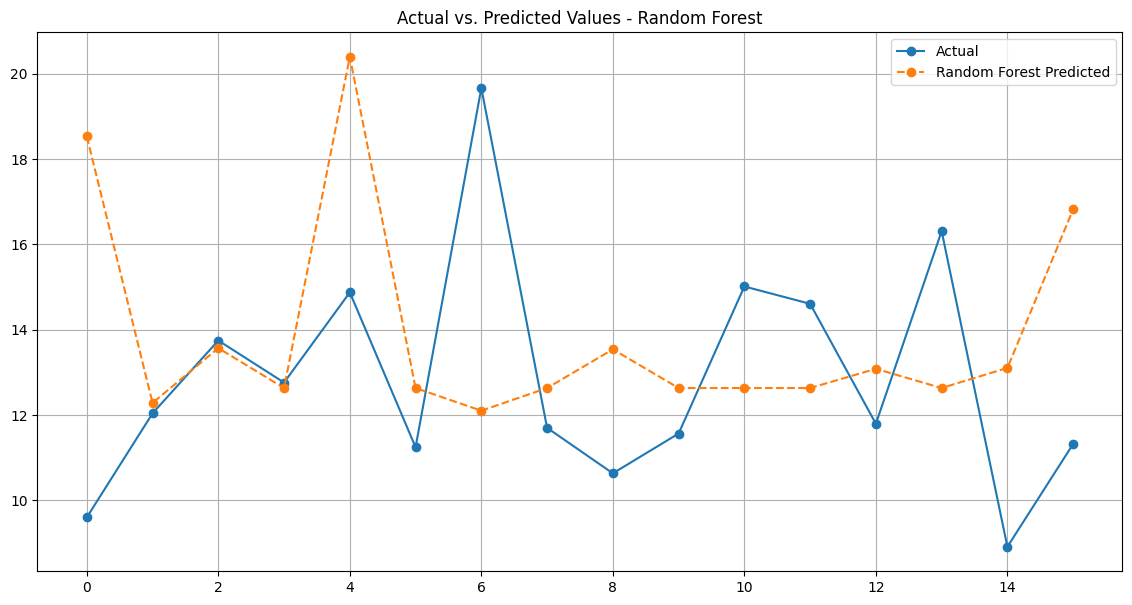


Results For Model: Random Forest
Best Hyperparameters: {'adaboost__learning_rate': 0.001, 'adaboost__loss': 'square', 'adaboost__n_estimators': 200}
Test RMSE: 4.0544
Test MSE: 16.4384
Test R2: -1.3544
Test MAE: 2.9280


,Actual,Predicted
0,9.60075,20.564157
1,12.03919,11.785780
2,13.74609,13.249527
3,12.76116,12.387852
4,14.87447,19.759114
5,11.24550,12.387852
6,19.66528,12.272163
7,11.69972,12.387852
8,10.63350,13.249527
9,11.56584,12.387852


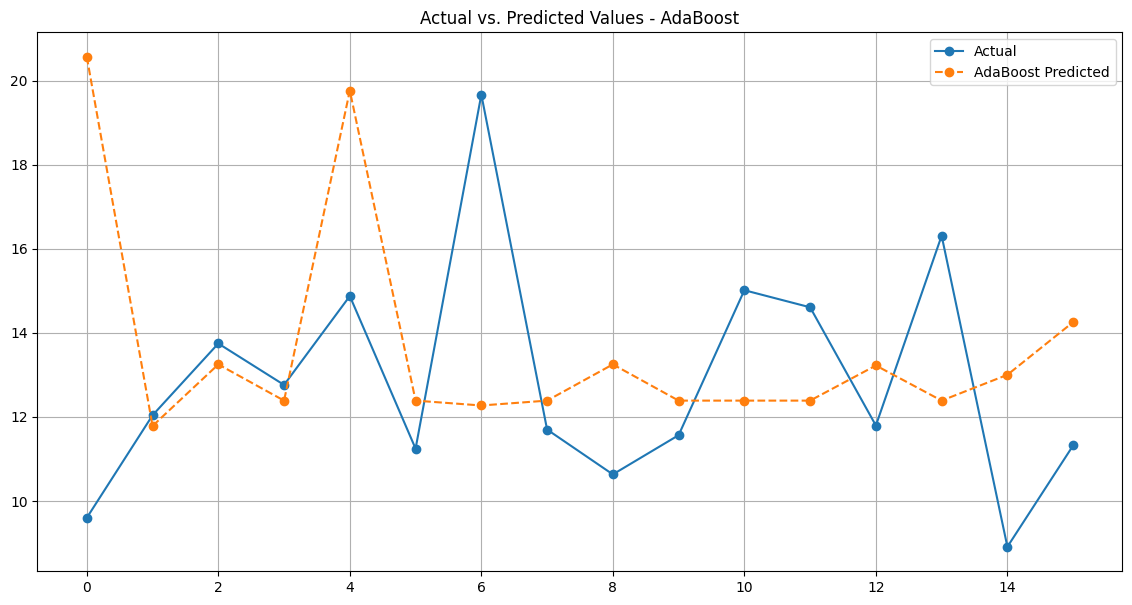

In [11]:
for result in results:
    print(f"Results For Model: {model_name}")
    model_name = result['name']
    print(f"Best Hyperparameters: {result['params']}")
    test_rmse = result['rmse']
    test_mse = result['mse']
    test_r2 = result['r2']
    test_mae = result['mae']
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [12]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,Linear Regression,2.647342,7.008418,-0.003789,2.235290
1,Ridge,2.647451,7.008995,-0.003872,2.235338
2,ElasticNet,2.672272,7.141036,-0.022783,2.245996
3,Lasso,2.674941,7.155312,-0.024828,2.247119
4,XGBoost,2.697937,7.278862,-0.042524,2.249592
5,Gradient Boosting,2.703594,7.309418,-0.046900,2.244306
6,K-Nearest Neighbors,3.364313,11.318600,-0.621120,2.716448
7,Random Forest,3.972466,15.780486,-1.260179,2.991833
8,AdaBoost,4.054425,16.438360,-1.354403,2.928001
